In [191]:
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
import seaborn
import json
import pandas as pd

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

pd.options.mode.chained_assignment = None

In [190]:
with open('spotipy_cred.json','r') as f:
    data = json.load(f) 
data

{'SPOTIPY_CLIENT_ID': '6f03a619b5424c0b92f9ce0dcb2841b3',
 'SPOTIPY_CLIENT_SECRET': '088dc108f86c4ae6ba1b3d3960d3fc20'}

In [3]:
#Authentication - without user
client_credentials_manager = SpotifyClientCredentials(client_id=data['SPOTIPY_CLIENT_ID'], client_secret=data['SPOTIPY_CLIENT_SECRET'])
sp = spotipy.Spotify(client_credentials_manager = client_credentials_manager)

In [4]:
playlist_link = "https://open.spotify.com/playlist/37i9dQZEVXbNG2KDcFcKOF?si=1333723a6eff4b7f"
playlist_URI = playlist_link.split("/")[-1].split("?")[0]
track_uris = [x["track"]["uri"] for x in sp.playlist_tracks(playlist_URI)["items"]]

In [5]:
playlist_list = []
features_list = []
for track in sp.playlist_tracks(playlist_URI)["items"]:
    #URI
    track_uri = track["track"]["uri"]
    
    #Track name
    track_name = track["track"]["name"]
    
    #Main Artist
    artist_uri = track["track"]["artists"][0]["uri"]
    artist_info = sp.artist(artist_uri)
    
    #Name, popularity, genre
    artist_name = track["track"]["artists"][0]["name"]
    artist_pop = artist_info["popularity"]
    artist_genres = artist_info["genres"]
    
    #Album
    album = track["track"]["album"]["name"]
    
    #Popularity of the track
    track_pop = track["track"]["popularity"]
    
    
    playlist_list.append(
        [track_uri, track_name, artist_uri, artist_info, artist_name, artist_pop, artist_genres, album, track_pop]
    )
    features_list.append(pd.DataFrame(sp.audio_features(track["track"]["uri"])))

In [6]:
playlist_df = pd.DataFrame(data = playlist_list, columns = ['track_uri', 'track_name', 'artist_uri',
                                              'artist_info', 'artist_name', 'artist_pop',
                                              'artist_genres', 'album', 'track_pop'])
full_music = playlist_df.merge(pd.concat(features_list), left_on = 'track_uri', right_on = 'uri')
full_music.head(2)

,track_uri,track_name,artist_uri,artist_info,artist_name,artist_pop,artist_genres,album,track_pop,danceability,...,liveness,valence,tempo,type,id,uri,track_href,analysis_url,duration_ms,time_signature
0,spotify:track:2tTmW7RDtMQtBk7m2rYeSw,"Quevedo: Bzrp Music Sessions, Vol. 52",spotify:artist:716NhGYqD1jl2wI1Qkgq36,{'external_urls': {'spotify': 'https://open.sp...,Bizarrap,87,"[argentine hip hop, pop venezolano, trap argen...","Quevedo: Bzrp Music Sessions, Vol. 52",100,0.621,...,0.230,0.550,128.033,audio_features,2tTmW7RDtMQtBk7m2rYeSw,spotify:track:2tTmW7RDtMQtBk7m2rYeSw,https://api.spotify.com/v1/tracks/2tTmW7RDtMQt...,https://api.spotify.com/v1/audio-analysis/2tTm...,198938,4
1,spotify:track:4Dvkj6JhhA12EX05fT7y2e,As It Was,spotify:artist:6KImCVD70vtIoJWnq6nGn3,{'external_urls': {'spotify': 'https://open.sp...,Harry Styles,91,[pop],Harry's House,93,0.520,...,0.311,0.662,173.930,audio_features,4Dvkj6JhhA12EX05fT7y2e,spotify:track:4Dvkj6JhhA12EX05fT7y2e,https://api.spotify.com/v1/tracks/4Dvkj6JhhA12...,https://api.spotify.com/v1/audio-analysis/4Dvk...,167303,4


In [7]:
full_music.columns

Index(['track_uri', 'track_name', 'artist_uri', 'artist_info', 'artist_name',
       'artist_pop', 'artist_genres', 'album', 'track_pop', 'danceability',
       'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness',
       'instrumentalness', 'liveness', 'valence', 'tempo', 'type', 'id', 'uri',
       'track_href', 'analysis_url', 'duration_ms', 'time_signature'],
      dtype='object')

In [8]:
full_music.artist_genres.iloc[0]

['argentine hip hop', 'pop venezolano', 'trap argentino']

In [9]:
def genre_list_extractor(genre_series):
    genre_set = set()
    for i in genre_series:
        for gen in i:
            genre_set.add(gen)
    genre_dict = dict()
    for i in genre_set:
         genre_dict[i] = genre_series.apply(lambda x:  1 if i in x else 0)
    return pd.DataFrame(genre_dict)

In [10]:
categorical_music = pd.concat([genre_list_extractor(full_music.artist_genres), full_music], axis=1)

In [11]:

typed = categorical_music.dtypes.reset_index()
catergories = list(typed[typed[0] != 'object']['index'].unique())
catergories.append('track_name')
numeric_mus = categorical_music[catergories]
numeric_mus.head(2)


,trap queen,r&b en espanol,big room,r&b,art rock,new wave pop,australian hip hop,shimmer pop,spanish hip hop,k-pop,...,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,track_name
0,0,0,0,0,0,0,0,0,0,0,...,1,0.0440,0.0125,0.03300,0.230,0.550,128.033,198938,4,"Quevedo: Bzrp Music Sessions, Vol. 52"
1,0,0,0,0,0,0,0,0,0,0,...,0,0.0557,0.3420,0.00101,0.311,0.662,173.930,167303,4,As It Was


In [12]:

categorical_music.head(1)

,trap queen,r&b en espanol,big room,r&b,art rock,new wave pop,australian hip hop,shimmer pop,spanish hip hop,k-pop,...,liveness,valence,tempo,type,id,uri,track_href,analysis_url,duration_ms,time_signature
0,0,0,0,0,0,0,0,0,0,0,...,0.23,0.55,128.033,audio_features,2tTmW7RDtMQtBk7m2rYeSw,spotify:track:2tTmW7RDtMQtBk7m2rYeSw,https://api.spotify.com/v1/tracks/2tTmW7RDtMQt...,https://api.spotify.com/v1/audio-analysis/2tTm...,198938,4


In [13]:
categorical_music.columns

Index(['trap queen', 'r&b en espanol', 'big room', 'r&b', 'art rock',
       'new wave pop', 'australian hip hop', 'shimmer pop', 'spanish hip hop',
       'k-pop', 'gen z singer-songwriter', 'reggaeton colombiano', 'chill pop',
       'canadian hip hop', 'trap latino', 'baroque pop', 'pop rap', 'uk dance',
       'pop dance', 'colombian pop', 'shiver pop', 'gauze pop',
       'post-teen pop', 'escape room', 'dfw rap', 'piano rock', 'viral pop',
       'rock', 'k-pop girl group', 'pop', 'minnesota hip hop',
       'deep groove house', 'dance pop', 'electropop', 'glam rock',
       'urbano espanol', 'modern alternative rock', 'uk pop', 'modern rock',
       'queens hip hop', 'latin', 'indietronica', 'reggaeton', 'hip pop',
       'canadian contemporary r&b', 'pop venezolano', 'permanent wave',
       'tropical house', 'hip hop', 'argentine hip hop', 'singer-songwriter',
       'latin pop', 'metal', 'edm', 'canadian pop', 'house', 'toronto rap',
       'rap', 'mellow gold', 'pop rock', '

C:\Users\zroga\anaconda3\envs\science\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\zroga\anaconda3\envs\science\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\zroga\anaconda3\envs\science\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\zroga\anaconda3\envs\science\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarn

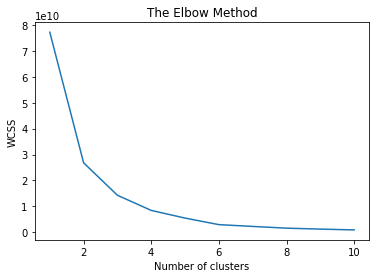

In [189]:
from sklearn.cluster import KMeans
from sklearn.cluster import KMeans
import numpy as np
wcss = []


for i in range(1,11):
    kmeans = KMeans(n_clusters=i,init='k-means++',max_iter=300,n_init=10,random_state=0)
    kmeans.fit(numeric_mus.drop(columns = ['track_name']))
    wcss.append(kmeans.inertia_)
plt.plot(range(1,11),wcss)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

In [15]:
[(wcss[x] - wcss[x+1])/(wcss[x+1]) for x in range(0, len(wcss) -1)]

[1.881132619735488,
 0.8774692925795837,
 0.6950097756326442,
 0.5422921438298541,
 0.8626779817983925,
 0.3087978416404039,
 0.42469513456622265,
 0.30449020153440937,
 0.348972090816077]

In [16]:
def cluster_data(data, n):
    new_df = pd.DataFrame()
    kmeans = KMeans(n_clusters=n, random_state=0)
    new_df['cluster'] = kmeans.fit_predict(data)
    
    centroids = kmeans.cluster_centers_
    
    cen_x = [i[0] for i in centroids] 
    cen_y = [i[1] for i in centroids]
    
    centroids = kmeans.cluster_centers_
    
    x_mapper = dict()
    y_mapper = dict()
    for i in range(0,n):
        x_mapper[i] = cen_x[0]
        y_mapper[i] = cen_y[0]
    
    new_df['cen_x'] = new_df.cluster.apply(lambda x:  x_mapper[x])
    new_df['cen_y'] = new_df.cluster.apply(lambda x:  y_mapper[x])
    
    return new_df, centroids

In [110]:
temp = pd.DataFrame(centers).describe().T
temp['relative'] = temp['std'] / (temp['max'] - temp['min'])
temp[(temp.relative < 0.57) & (temp.relative > 0.50 )]

,count,mean,std,min,25%,50%,75%,max,relative
14,3.0,0.257937,0.095486,1.666667e-01,0.208333,0.250000,0.303571,0.357143,0.501300
26,3.0,0.051587,0.045071,-6.938894e-18,0.035714,0.071429,0.077381,0.083333,0.540848
29,3.0,0.359127,0.066904,2.857143e-01,0.330357,0.375000,0.395833,0.416667,0.510900
32,3.0,0.138889,0.127294,2.775558e-17,0.083333,0.166667,0.208333,0.250000,0.509175
38,3.0,0.051587,0.045071,-6.938894e-18,0.035714,0.071429,0.077381,0.083333,0.540848
40,3.0,0.244048,0.142981,8.333333e-02,0.187500,0.291667,0.324405,0.357143,0.522192
42,3.0,0.257937,0.095486,1.666667e-01,0.208333,0.250000,0.303571,0.357143,0.501300
44,3.0,0.037698,0.035879,6.938894e-18,0.020833,0.041667,0.056548,0.071429,0.502309
54,3.0,0.089286,0.050857,4.166667e-02,0.062500,0.083333,0.113095,0.142857,0.502588
57,3.0,0.051587,0.045071,-1.387779e-17,0.035714,0.071429,0.077381,0.083333,0.540848


In [17]:
clus, centers = cluster_data(numeric_mus.drop(columns = ['track_name']), 3)

clustered =  pd.concat([numeric_mus, clus], axis=1)
clustered.head(2)

C:\Users\zroga\anaconda3\envs\science\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


,trap queen,r&b en espanol,big room,r&b,art rock,new wave pop,australian hip hop,shimmer pop,spanish hip hop,k-pop,...,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,track_name,cluster,cen_x,cen_y
0,0,0,0,0,0,0,0,0,0,0,...,0.03300,0.230,0.550,128.033,198938,4,"Quevedo: Bzrp Music Sessions, Vol. 52",2,3.469447e-18,0.166667
1,0,0,0,0,0,0,0,0,0,0,...,0.00101,0.311,0.662,173.930,167303,4,As It Was,0,3.469447e-18,0.166667


In [73]:


#colors = ['#DF2020', '#81DF20', '#2095DF']
colors = ['r', 'g', 'b', 'o', 'i']
clustered['c'] = clustered.cluster.apply(lambda x: colors[x])
clustered.head(2)

,trap queen,r&b en espanol,big room,r&b,art rock,new wave pop,australian hip hop,shimmer pop,spanish hip hop,k-pop,...,liveness,valence,tempo,duration_ms,time_signature,track_name,cluster,cen_x,cen_y,c
0,0,0,0,0,0,0,0,0,0,0,...,0.230,0.550,128.033,198938,4,"Quevedo: Bzrp Music Sessions, Vol. 52",2,3.469447e-18,0.166667,b
1,0,0,0,0,0,0,0,0,0,0,...,0.311,0.662,173.930,167303,4,As It Was,0,3.469447e-18,0.166667,r


In [176]:
def plot_axis_cluster(clust, cent, cat1, cat2):
    divisor = 4
    
    plt.scatter(clust[cat1], clust[cat2], c = clust.c, alpha = 0.6, s=10)
    num1 = clust.columns.get_loc(cat1)
    num2 = clust.columns.get_loc(cat2)
    for i in range(0,len(cent)):
        plt.plot(cent[i][num1], cent[i][num2], 'v', c = 'black')
        #print(i[num1], i[num2])
        
    for i, row in clustered.iterrows():
        if i % divisor == 0:
            plt.text(row[cat1], row[cat2], row.track_name)
            
    plt.xlabel(cat1)
    plt.ylabel(cat2)
    
    return plt
    
    

<module 'matplotlib.pyplot' from 'C:\\Users\\zroga\\anaconda3\\envs\\science\\lib\\site-packages\\matplotlib\\pyplot.py'>

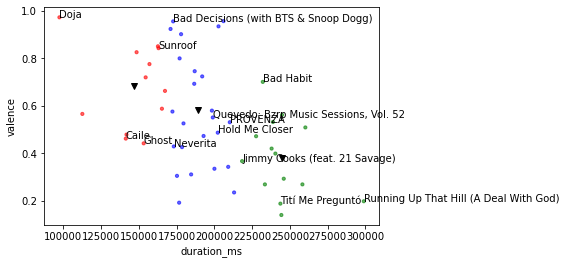

In [177]:
plter = plot_axis_cluster(clustered, centers, 'duration_ms', 'valence')
plter

<module 'matplotlib.pyplot' from 'C:\\Users\\zroga\\anaconda3\\envs\\science\\lib\\site-packages\\matplotlib\\pyplot.py'>

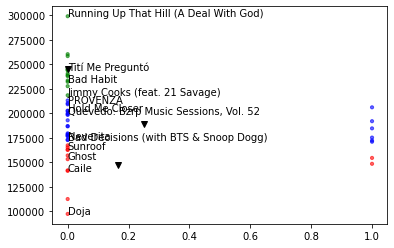

In [175]:
plter = plot_axis_cluster(clustered, centers, 'dance pop', 'duration_ms')
plter

<module 'matplotlib.pyplot' from 'C:\\Users\\zroga\\anaconda3\\envs\\science\\lib\\site-packages\\matplotlib\\pyplot.py'>

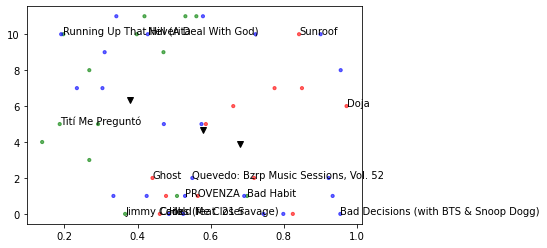

In [144]:
plter = plot_axis_cluster(clustered, centers, 'valence', 'key')
plter